In [21]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#import plotly.express as px

from pandas_profiling import ProfileReport
from sklearn import metrics
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier

In [52]:
KAGGLE_EVAL_METRIC = 'logloss' # string name for loss function in xgboost

In [22]:
TRAIN_PATH = "data/train.csv"
TEST_PATH = "data/test.csv"

# Load Data

In [23]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

In [37]:
categorical = ['Pclass','Name','Sex','Ticket','Cabin','Embarked']
ordinal = ['Age','SibSp','Parch','Fare']
target = "Survived"
features = categorical + ordinal

In [25]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Profile Data

In [6]:
profile = ProfileReport(train, title="Pandas Profiling Report")

profile.to_notebook_iframe()

# Additional Visualization

# Pre-Processing

First, let's combine train + test to ensure they receive the same preproccessing (category indexs)

In [26]:
train['label'] = 'train'
test['label'] = 'test'

to_clean = train.append(test)

---

## NULLS
To start we'll use XGBOOST and let the algo deal with nulll.
- Age: 
- SibSpa
- Parch
- Fare:
- Embark: 

Future iterations, we can improve score by doing a better job with our NULL values.

In [27]:
#train = train.fillna(-1)
#test = test.fillna(-1)

--- 

## Categorical Data
Transform categorical features to integer representatins

In [28]:
# categorical encoding
def objects_to_category(df):
    '''
    function that converts objects to categorical features.
    '''
    object_cols = df.columns.tolist()
    object_features = df[object_cols].astype("category")
    for field in object_cols:
        df[field] = object_features[field].cat.codes
    return df

to_clean[categorical] = objects_to_category(to_clean[categorical])
to_clean[categorical] = objects_to_category(to_clean[categorical])

<ipython-input-28-e4c6efef39e0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[field] = object_features[field].cat.codes


In [29]:
to_clean.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,label
0,1,0.0,2,155,1,22.0,1,0,720,7.2500,0,3,train
1,2,1.0,0,286,0,38.0,1,0,816,71.2833,107,1,train
2,3,1.0,2,523,0,26.0,0,0,914,7.9250,0,3,train
3,4,1.0,0,422,0,35.0,1,0,65,53.1000,71,3,train
4,5,0.0,2,22,1,35.0,0,0,649,8.0500,0,3,train


## Drop Features
uncommend the below code if you want  to drop features

In [44]:
print(features)

['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age', 'SibSp', 'Parch', 'Fare']


In [45]:
#drop = []
#to_clean = to_clean[features].drop(drop, axis=1)

## Done

Seperate train & test sets again

In [31]:
train = to_clean[to_clean['label'] == 'train'].drop('label',axis=1)
test = to_clean[to_clean['label'] == 'test'].drop('label',axis=1)

Drop features that we don't want to use

In [41]:
print(features)

['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age', 'SibSp', 'Parch', 'Fare']


# Modeling

In [35]:
train[features]

,Pclass,Name,Sex,Ticket,Cabin,Embarked,Age,SibSp,Parch,Fare
0,2,155,1,720,0,3,22.0,1,0,7.2500
1,0,286,0,816,107,1,38.0,1,0,71.2833
2,2,523,0,914,0,3,26.0,0,0,7.9250
3,0,422,0,65,71,3,35.0,1,0,53.1000
4,2,22,1,649,0,3,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...,...,...
886,1,811,1,130,0,3,27.0,0,0,13.0000
887,0,464,0,18,41,3,19.0,0,0,30.0000
888,2,607,0,923,0,3,NaN,1,2,23.4500
889,0,113,1,11,78,1,26.0,0,0,30.0000


In [39]:
print(features)

['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age', 'SibSp', 'Parch', 'Fare']


In [40]:
#drop [""]
#train = train[features].drop(drop, axis=1)

In [46]:
X = train[features]
y = train[target]

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [53]:
#View notbook for details on  Parameter Tuning
clf = XGBClassifier(max_depth=4,
                    min_child_weight=1,
                    learning_rate=0.05,
                    n_estimators=100,
                    silent=True,
                    objective='binary:logistic',
                    #gamma=4,
                    #max_delta_step=0,
                    #subsample=0.88,
                    #colsample_bytree=1,
                    #colsample_bylevel=1,
                    #reg_alpha=0,
                    #reg_lambda=0,
                    #scale_pos_weight=1,
                    #seed=1,
                    #missing=None,
                    #enable_categorical=True
                    )

clf.fit(
    X_train,
    y_train,
    eval_metric=KAGGLE_EVAL_METRIC,
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=False,
    early_stopping_rounds = 10
)

[12:58:55] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

/home/neil/anaconda3/envs/ds_py_3.8/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


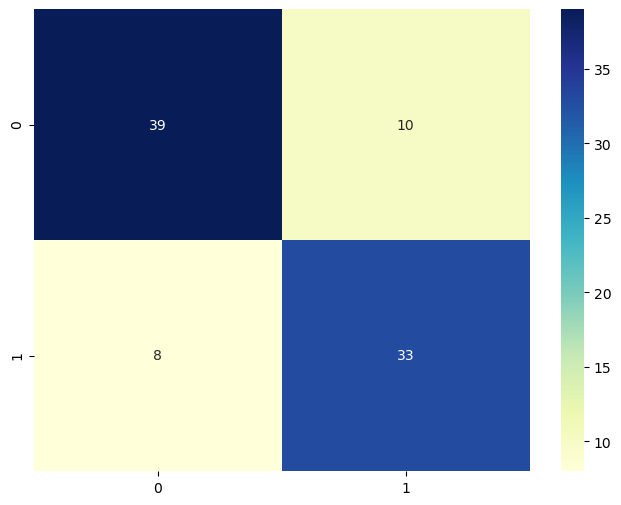

0.3969867950098382
0.8
0.880537580886013
0.12569072946271334
0.7857142857142858
0.8048780487804879
0.7674418604651163
0.7065859960925192


In [54]:
# riding style null fixed
## Create Report
y_pred = clf.predict(X_test)
probs = clf.predict_proba(X_test)

results = pd.DataFrame(y_test)
#temp = pd.DataFrame(probs)
results['actual_classification'] = y_test
results['predicted_classification'] = y_pred
results['buy_prob_28'] = probs[:,1]

plt.rcParams["figure.figsize"] = (8, 6)
matrix = metrics.confusion_matrix(results['actual_classification'], results['predicted_classification'])
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.show()
#classification summary stats
print(metrics.log_loss(results['actual_classification'],results['buy_prob_28']))
print(metrics.accuracy_score(results['actual_classification'], results['predicted_classification']))
print(metrics.roc_auc_score(results['actual_classification'],results['buy_prob_28']))
print(metrics.brier_score_loss(results['actual_classification'],results['buy_prob_28']))
print(metrics.f1_score(results['actual_classification'], results['predicted_classification']))
print(metrics.recall_score(results['actual_classification'], results['predicted_classification']))
print(metrics.precision_score(results['actual_classification'], results['predicted_classification']))
print(metrics.average_precision_score(results['actual_classification'], results['predicted_classification']))